# Import Libraries

In [1]:
# Scientific
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine Learning 
from sklearn.model_selection import train_test_split

# Depp Learning
import keras
from keras.models import *
from keras.layers import *

# OS
import glob
import os 

# Image
import cv2
from PIL import Image

# Scraping
import requests

# Multi-thread
import concurrent.futures

#Others
from warnings import filterwarnings

2023-06-05 23:43:26.432673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read Images

In [2]:
captcha_sets = {}

# 1. reading images into a dictionary
for image in glob.glob('../dataset/*'):

    if len(image.split('/')[-1].split('-')[-1].split('.')[0]) != 4:
        print(image.split('/')[-1])
    
    # Extract label 
    number = image.split('/')[-1].split('-')[-1].split('.')[0]
    
    captcha = cv2.imread(image)
    captcha_sets[number] = captcha
    

# Crop Images

In [3]:
def crop_digits(image):
    # cropping captcha into 5 overlapping images
    kernel_size = 27
    stride = 30
    start = 0
    while start+stride<image.shape[1]:
        yield image[:, start:start+kernel_size, :]
        start += stride

# How To Crop Images

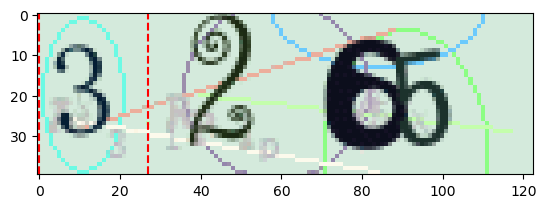

In [4]:
plt.imshow(captcha_sets['3265'])
plt.axvline(0, color='red', linestyle='--')
plt.axvline(27, color='red', linestyle='--')
#plt.axis('off')

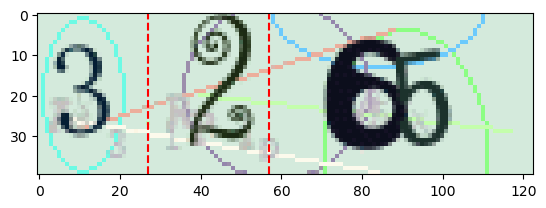

In [5]:
plt.imshow(captcha_sets['3265'])
plt.axvline(27, color='red', linestyle='--')
plt.axvline(57, color='red', linestyle='--')
#plt.axis('off')

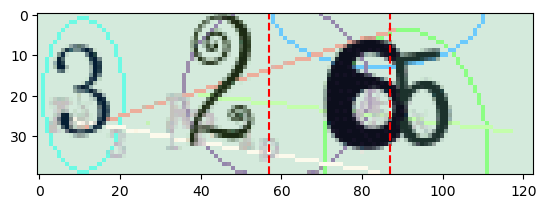

In [6]:
plt.imshow(captcha_sets['3265'])
plt.axvline(57, color='red', linestyle='--')
plt.axvline(87, color='red', linestyle='--')
#plt.axis('off')

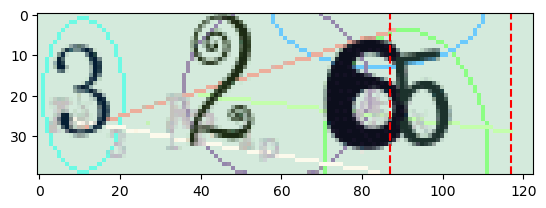

In [7]:
plt.imshow(captcha_sets['3265'])
plt.axvline(87, color='red', linestyle='--')
plt.axvline(117, color='red', linestyle='--')
#plt.axis('off')

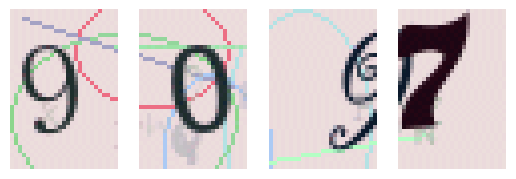

In [8]:
for i, image in enumerate(crop_digits(captcha_sets['9097'])):
    plt.subplot(1, 4, i+1)
    plt.imshow(image)
    plt.axis('off')

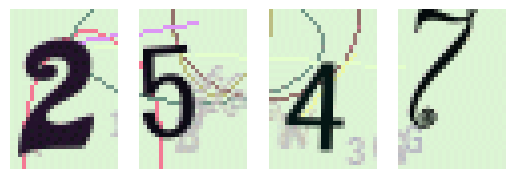

In [9]:
for i, image in enumerate(crop_digits(captcha_sets[np.random.choice(list(captcha_sets.keys()))])):
    plt.subplot(1, 4, i+1)
    plt.imshow(image)
    plt.axis('off')

# Generate X, Y

In [10]:
def generate_Xy():
    X = []
    y = []

    for number, captcha in captcha_sets.items():
        y.extend(list(map(int, list(number))))
        
        X.extend(list(crop_digits(captcha)))
            
    return np.array(X), np.array(y)

In [11]:
X, Y = generate_Xy()

X = X/255

X = X.mean(axis=3).reshape(-1, 40, 27, 1)

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

# Model Architecture

In [19]:
model = Sequential()
model.add(Conv2D(64, 4, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(MaxPool2D(2))
model.add(Conv2D(64, 4, activation='relu', padding='same'))
model.add(MaxPool2D(2))
model.add(Conv2D(32, 4, activation='relu', padding='same'))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 40, 27, 64)        1088      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 13, 64)        65600     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 6, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 6, 32)         32800     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 3, 32)        

In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/15
248/248 [==============================] - 19s 75ms/step - loss: 1.0995 - accuracy: 0.6037 - val_loss: 0.1383 - val_accuracy: 0.9535
Epoch 2/15
248/248 [==============================] - 19s 76ms/step - loss: 0.0735 - accuracy: 0.9832 - val_loss: 0.0663 - val_accuracy: 0.9819
Epoch 3/15
248/248 [==============================] - 20s 80ms/step - loss: 0.0306 - accuracy: 0.9934 - val_loss: 0.0191 - val_accuracy: 0.9989
Epoch 4/15
248/248 [==============================] - 20s 80ms/step - loss: 0.0287 - accuracy: 0.9947 - val_loss: 0.0151 - val_accuracy: 0.9955
Epoch 5/15
248/248 [==============================] - 20s 82ms/step - loss: 0.0197 - accuracy: 0.9965 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 6/15
248/248 [==============================] - 21s 83ms/step - loss: 0.0167 - accuracy: 0.9966 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 7/15
248/248 [==============================] - 20s 82ms/step - loss: 0.0137 - accuracy: 0.9974 - val_loss: 0.0071 - val_accuracy:

In [17]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.xlabel('Epoch')

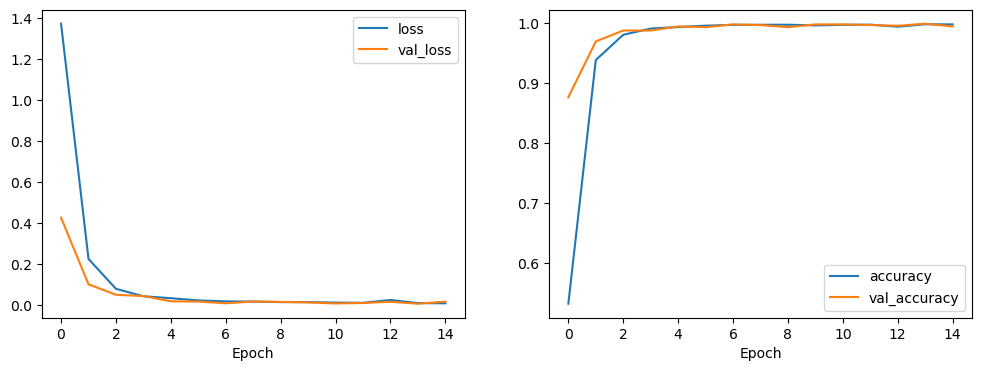

In [18]:
plot_history(history)

# Test Model

In [49]:
def predict(captcha):
    digits = []
    predicts = []
    
    digits = np.asarray(list(crop_digits(captcha))) / 255
    for digit in digits:
        digit = digit.mean(axis=2).reshape(-1, 40, 27, 1)
        predicts.append(model.predict(digit).argmax())
        
    return predicts

1/1 [==============================] - 0s 55ms/step


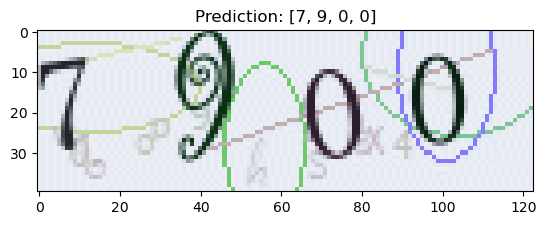

Enter T or F: t
1/1 [==============================] - 0s 44ms/step


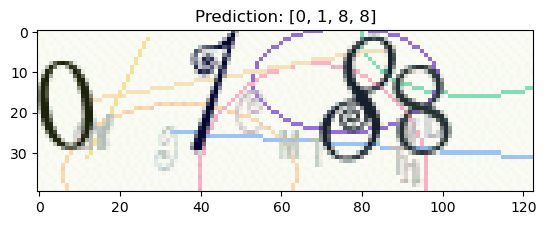

Enter T or F: t
1/1 [==============================] - 0s 60ms/step


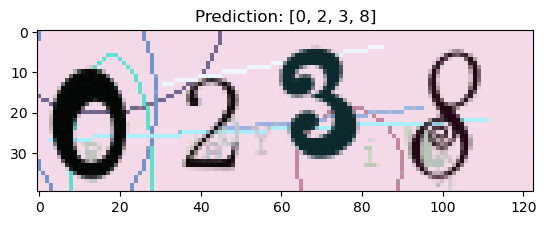

Enter T or F: t
1/1 [==============================] - 0s 48ms/step


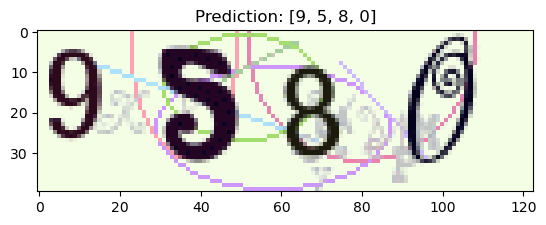

Enter T or F: t
1/1 [==============================] - 0s 42ms/step


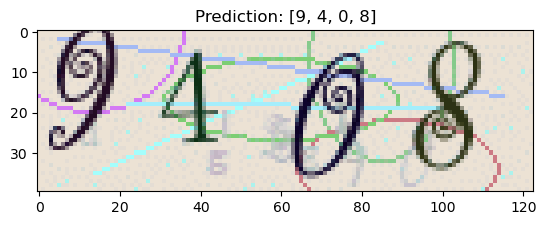

Enter T or F: t
1/1 [==============================] - 0s 17ms/step


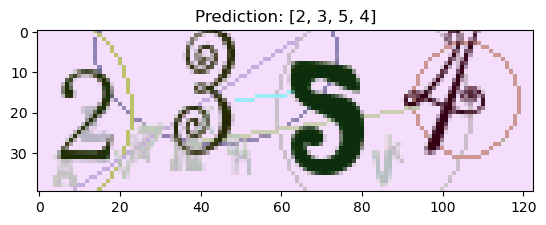

Enter T or F: t
1/1 [==============================] - 0s 52ms/step


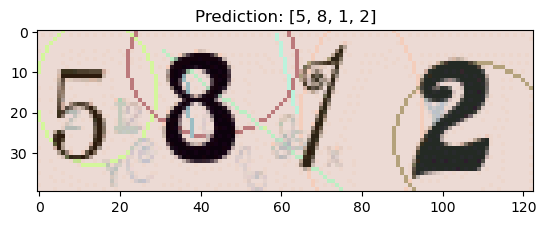

Enter T or F: t
1/1 [==============================] - 0s 49ms/step


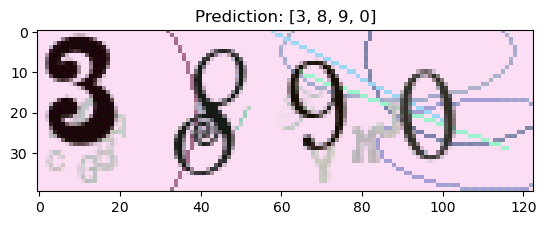

Enter T or F: t
1/1 [==============================] - 0s 44ms/step


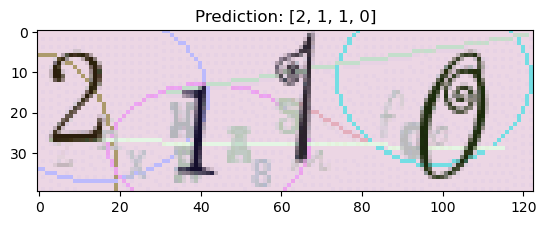

Enter T or F: t
1/1 [==============================] - 0s 47ms/step


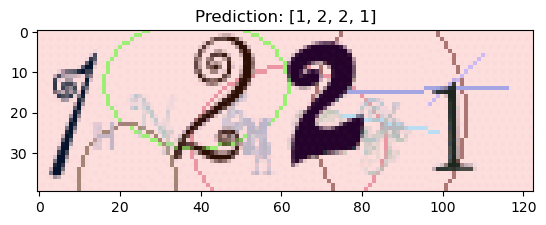

Enter T or F: t
1/1 [==============================] - 0s 59ms/step


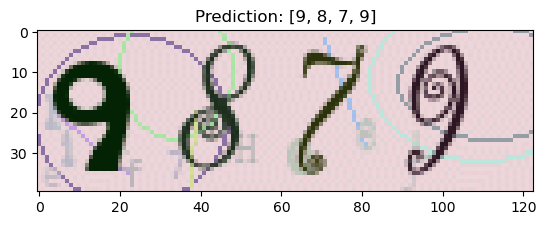

Enter T or F: t
1/1 [==============================] - 0s 42ms/step


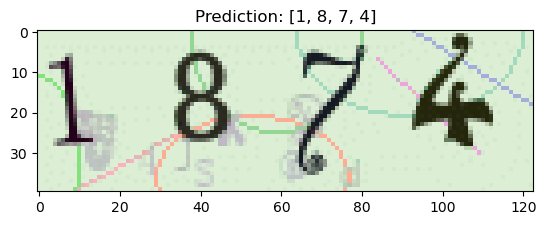

Enter T or F: t
1/1 [==============================] - 0s 47ms/step


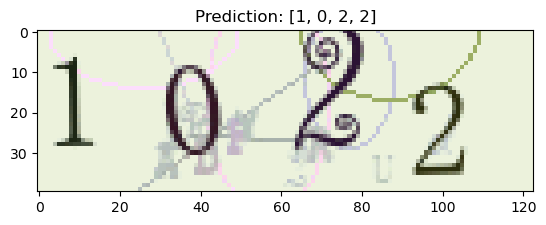

Enter T or F: t
1/1 [==============================] - 0s 49ms/step


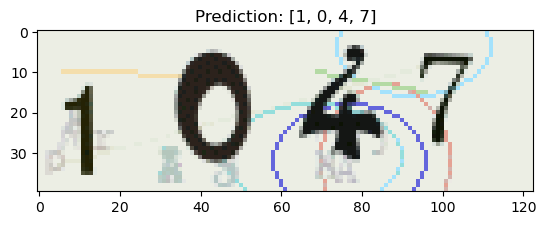

Enter T or F: t
1/1 [==============================] - 0s 42ms/step


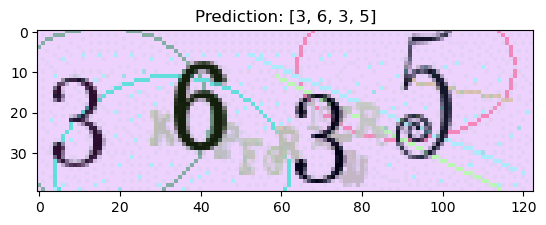

Enter T or F: t
1/1 [==============================] - 0s 53ms/step


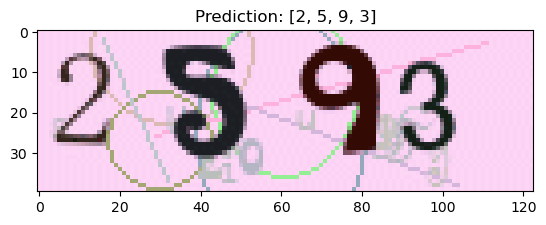

Enter T or F: t
1/1 [==============================] - 0s 49ms/step


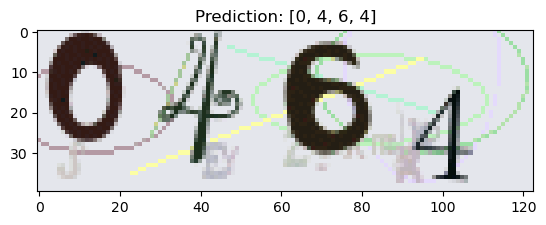

Enter T or F: t
1/1 [==============================] - 0s 46ms/step


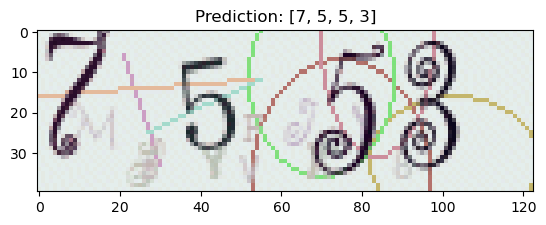

Enter T or F: t
1/1 [==============================] - 0s 52ms/step


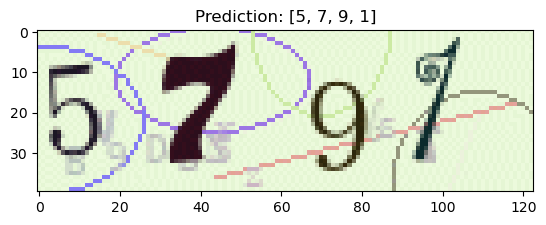

Enter T or F: t
1/1 [==============================] - 0s 58ms/step


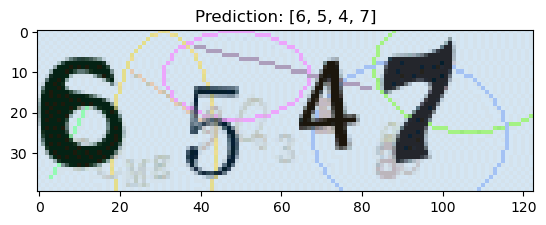

Enter T or F: t
1/1 [==============================] - 0s 46ms/step


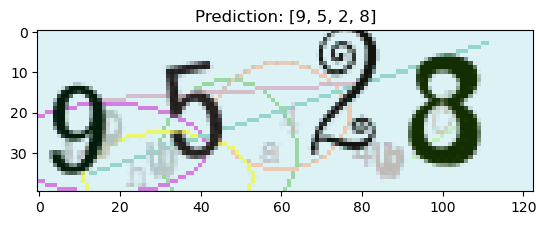

Enter T or F: t
1/1 [==============================] - 0s 46ms/step


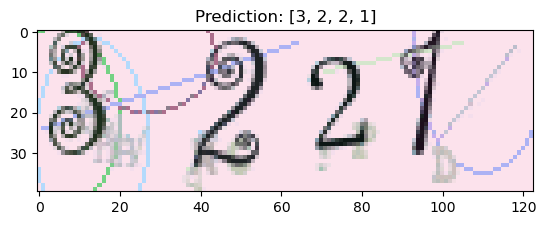

Enter T or F: t
1/1 [==============================] - 0s 19ms/step


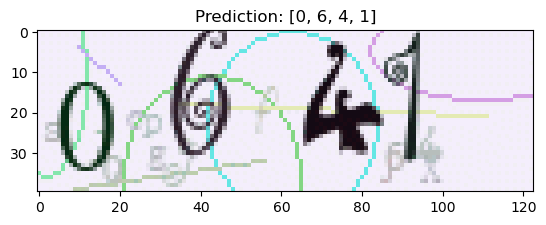

Enter T or F: t
1/1 [==============================] - 0s 48ms/step


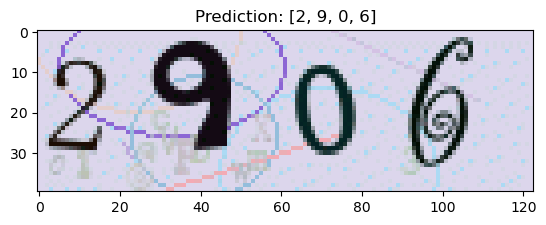

Enter T or F: t
1/1 [==============================] - 0s 58ms/step


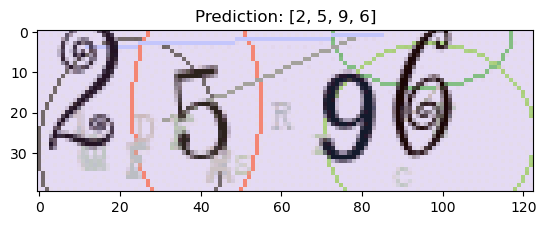

Enter T or F: t
1/1 [==============================] - 0s 47ms/step


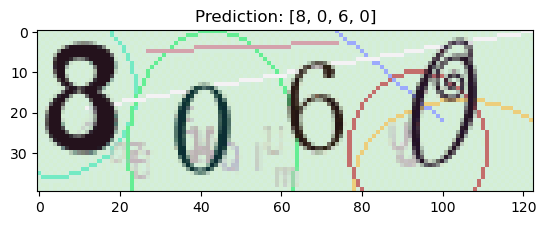

Enter T or F: t
1/1 [==============================] - 0s 52ms/step


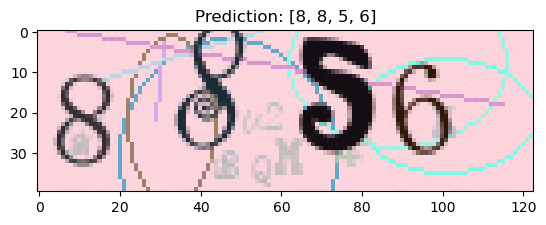

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


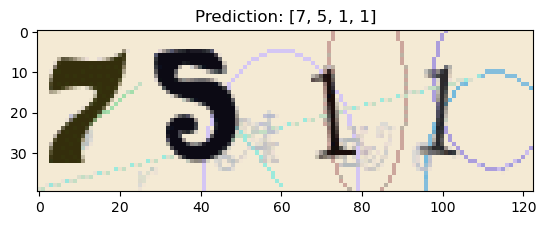

Enter T or F: t
1/1 [==============================] - 0s 42ms/step


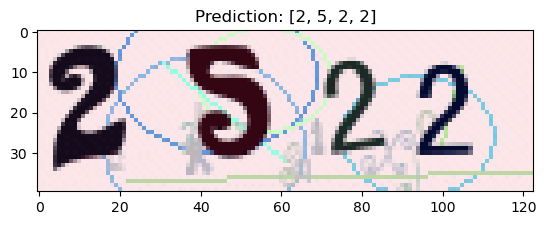

Enter T or F: t
1/1 [==============================] - 0s 54ms/step


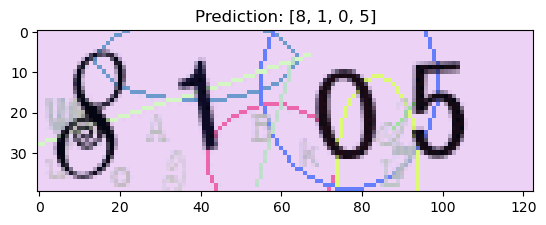

Enter T or F: t
1/1 [==============================] - 0s 42ms/step


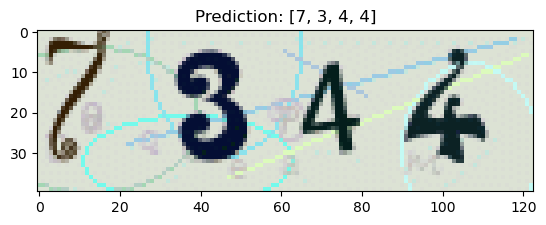

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


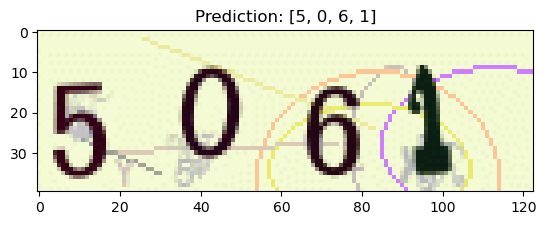

Enter T or F: t
1/1 [==============================] - 0s 50ms/step


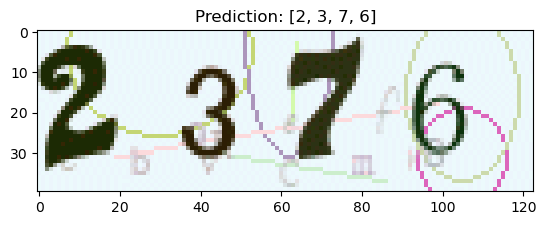

Enter T or F: t
1/1 [==============================] - 0s 57ms/step


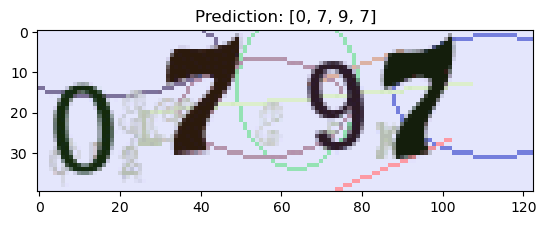

Enter T or F: t
1/1 [==============================] - 0s 51ms/step


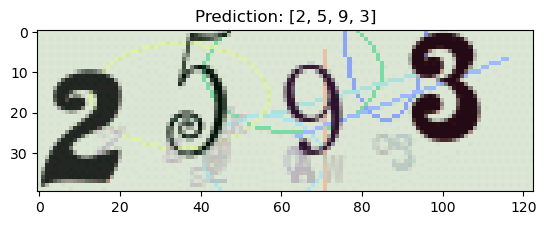

Enter T or F: t
1/1 [==============================] - 0s 45ms/step


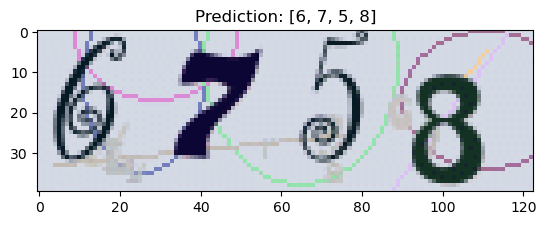

Enter T or F: t
1/1 [==============================] - 0s 46ms/step


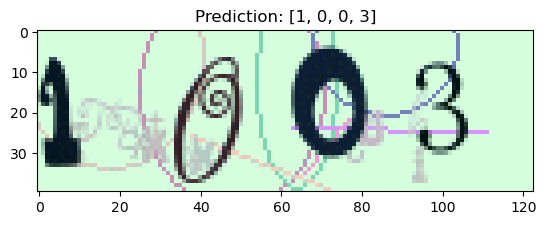

Enter T or F: t
1/1 [==============================] - 0s 40ms/step


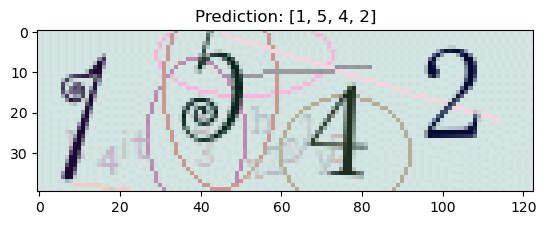

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


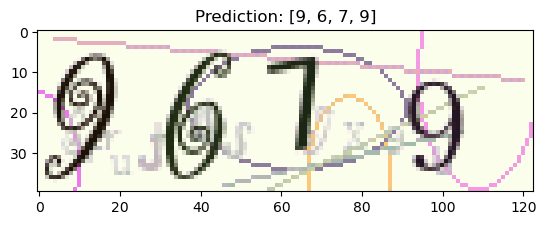

Enter T or F: t
1/1 [==============================] - 0s 45ms/step


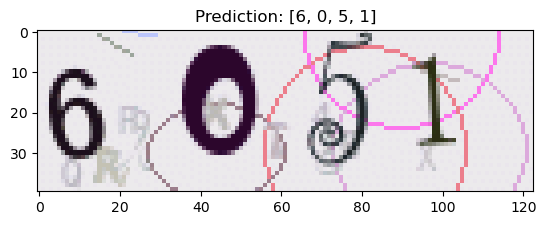

Enter T or F: t
1/1 [==============================] - 0s 53ms/step


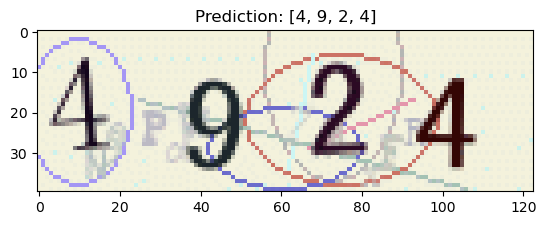

Enter T or F: t
1/1 [==============================] - 0s 46ms/step


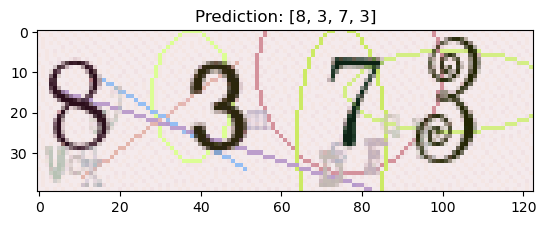

Enter T or F: t
1/1 [==============================] - 0s 56ms/step


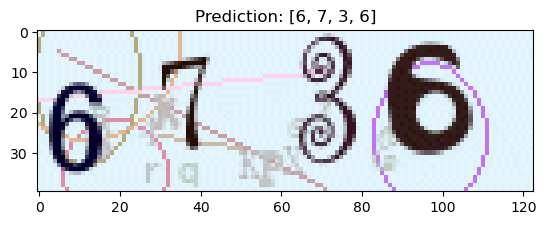

Enter T or F: t
1/1 [==============================] - 0s 44ms/step


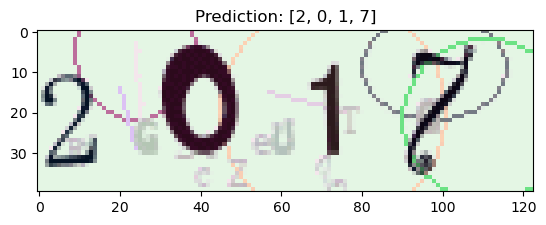

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


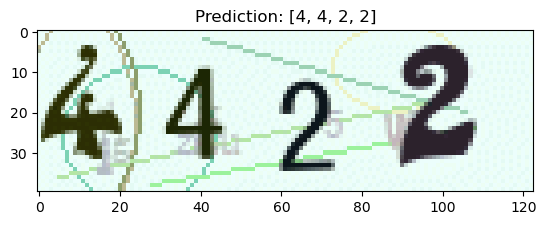

Enter T or F: t
1/1 [==============================] - 0s 81ms/step


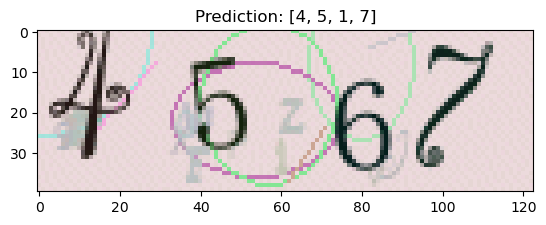

Enter T or F: f
1/1 [==============================] - 0s 43ms/step


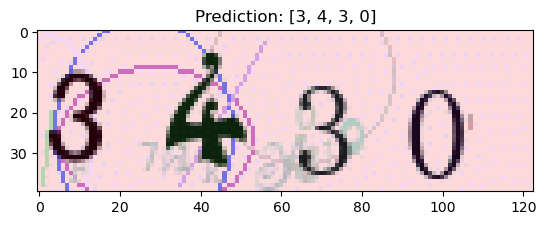

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


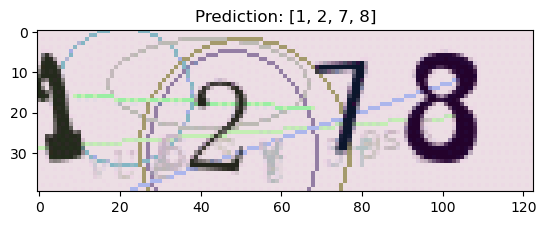

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


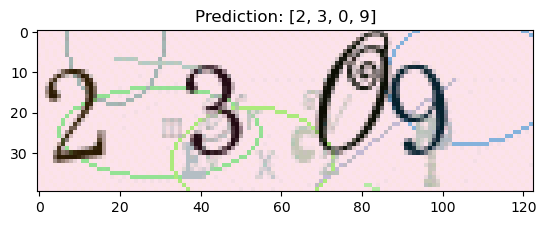

Enter T or F: t
1/1 [==============================] - 0s 40ms/step


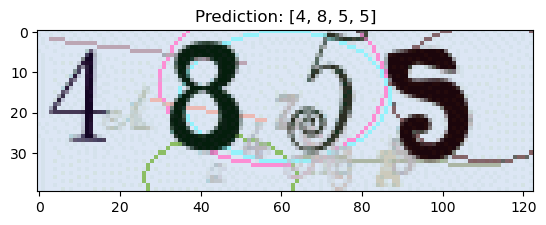

Enter T or F: t
1/1 [==============================] - 0s 48ms/step


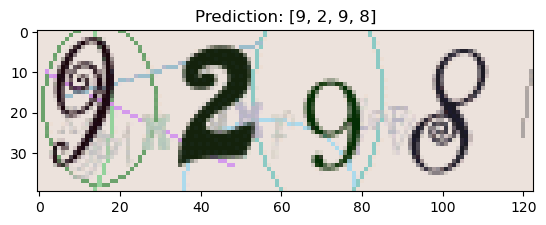

Enter T or F: t
1/1 [==============================] - 0s 46ms/step


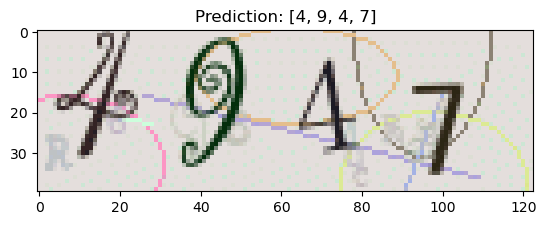

Enter T or F: t
1/1 [==============================] - 0s 68ms/step


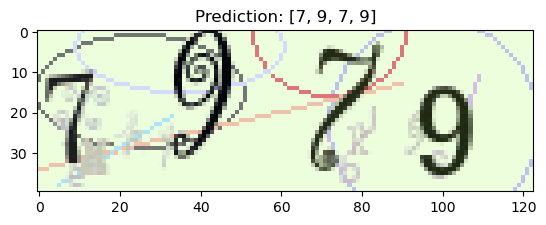

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


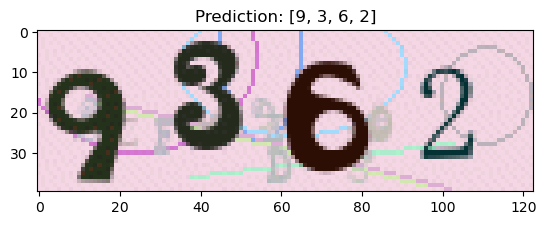

Enter T or F: t
1/1 [==============================] - 0s 48ms/step


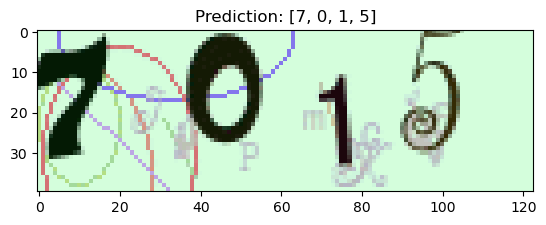

Enter T or F: t
1/1 [==============================] - 0s 39ms/step


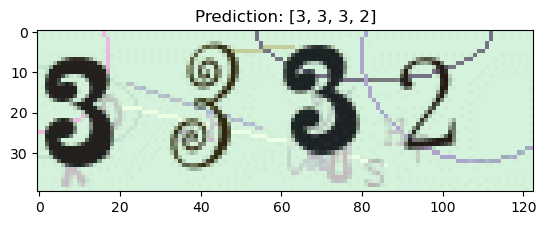

Enter T or F: t
1/1 [==============================] - 0s 48ms/step


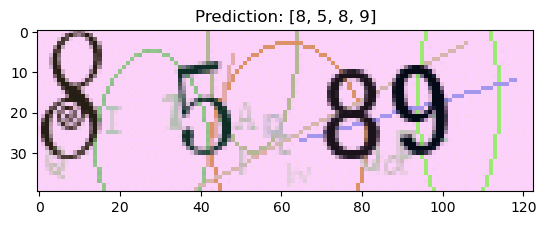

Enter T or F: t
1/1 [==============================] - 0s 65ms/step


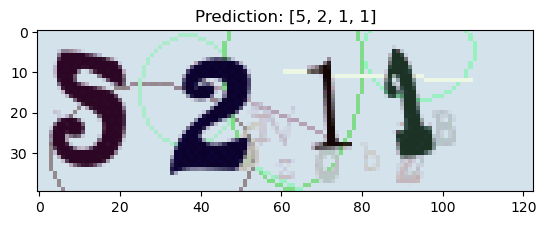

Enter T or F: t
1/1 [==============================] - 0s 44ms/step


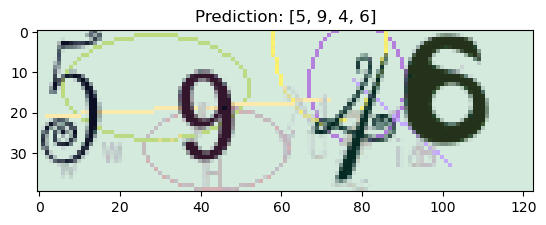

Enter T or F: t
1/1 [==============================] - 0s 51ms/step


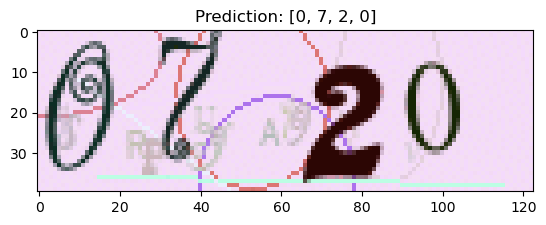

Enter T or F: t
1/1 [==============================] - 0s 40ms/step


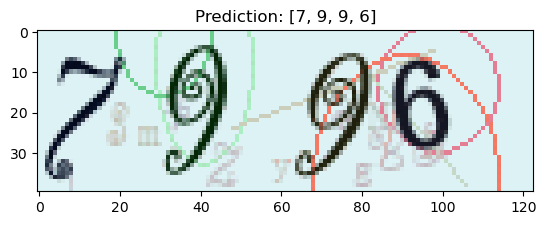

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


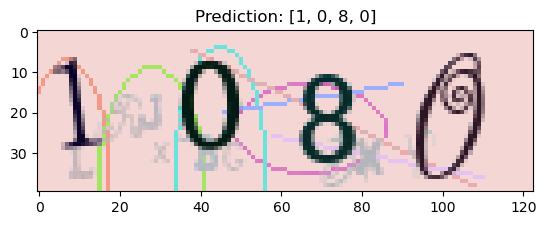

Enter T or F: t
1/1 [==============================] - 0s 38ms/step


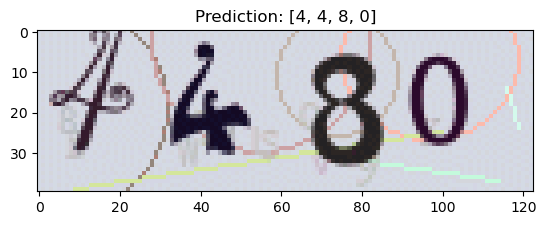

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


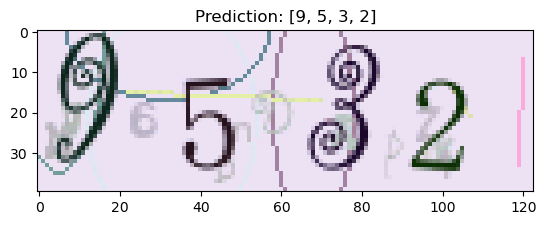

Enter T or F: t
1/1 [==============================] - 0s 42ms/step


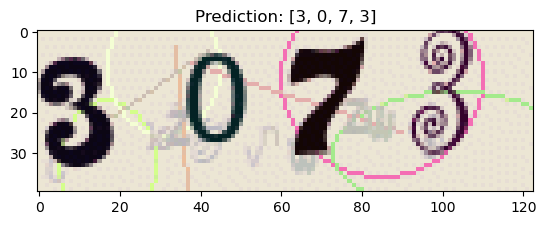

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


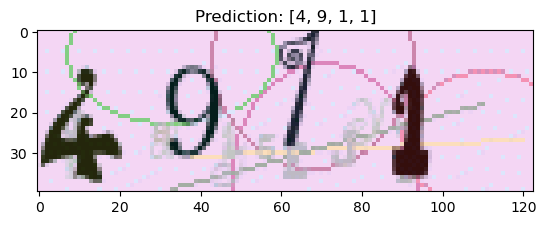

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


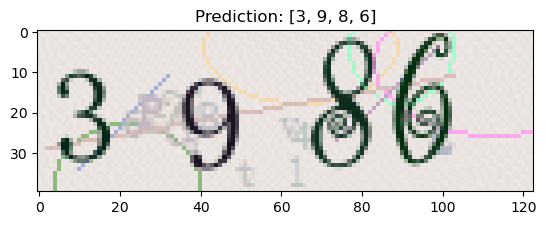

Enter T or F: t
1/1 [==============================] - 0s 61ms/step


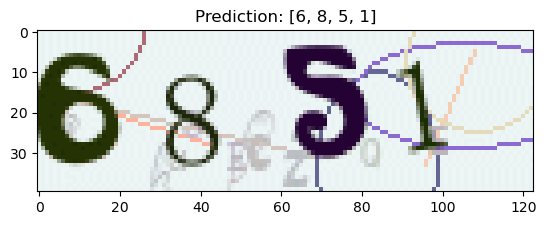

Enter T or F: t
1/1 [==============================] - 0s 38ms/step


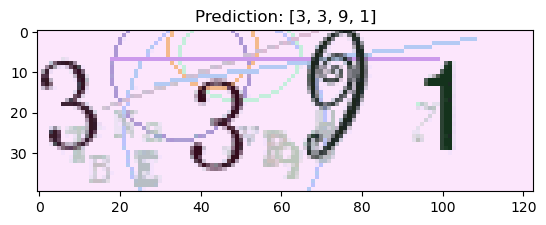

Enter T or F: t
1/1 [==============================] - 0s 47ms/step


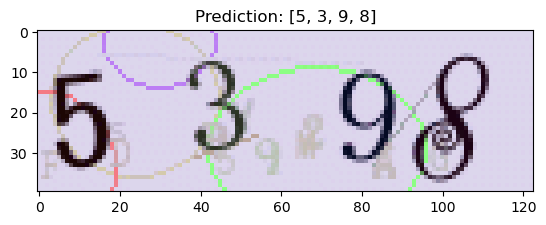

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


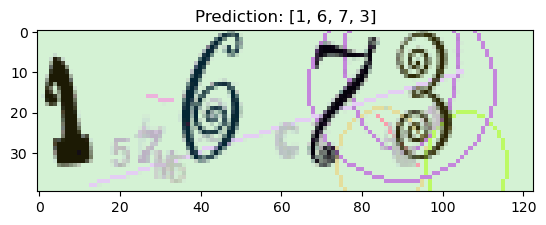

Enter T or F: t
1/1 [==============================] - 0s 40ms/step


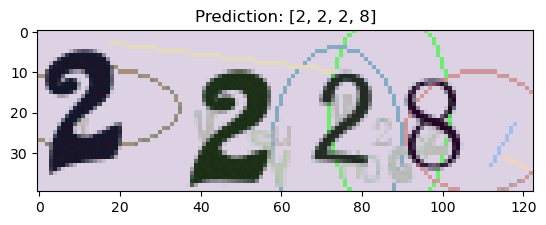

Enter T or F: t
1/1 [==============================] - 0s 52ms/step


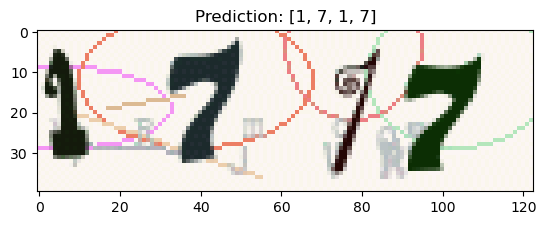

Enter T or F: t
1/1 [==============================] - 0s 45ms/step


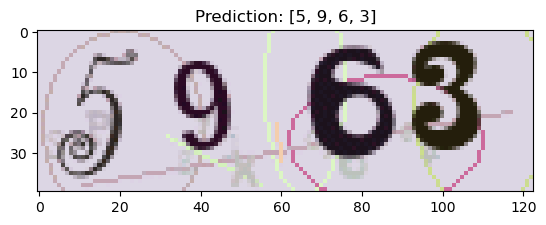

Enter T or F: t
1/1 [==============================] - 0s 45ms/step


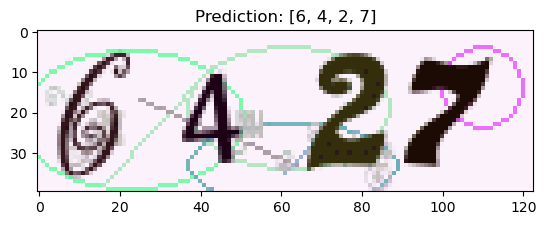

Enter T or F: t
1/1 [==============================] - 0s 49ms/step


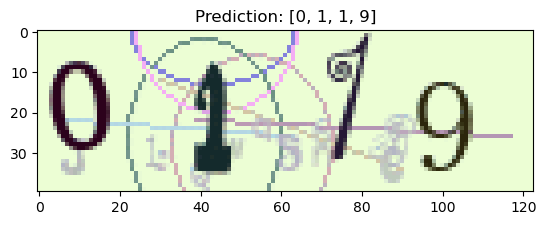

Enter T or F: t
1/1 [==============================] - 0s 46ms/step


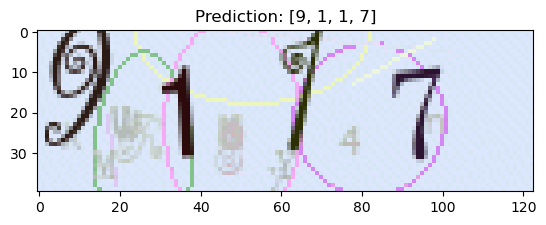

Enter T or F: t
1/1 [==============================] - 0s 51ms/step


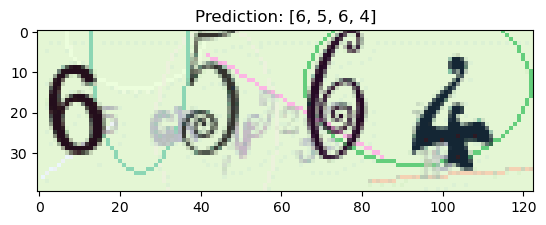

Enter T or F: t
1/1 [==============================] - 0s 48ms/step


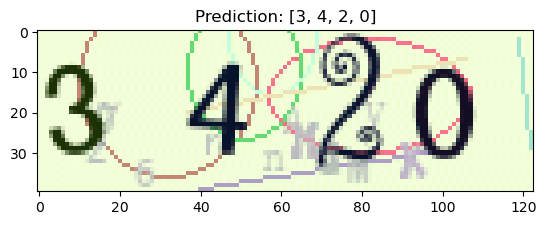

Enter T or F: t
1/1 [==============================] - 0s 45ms/step


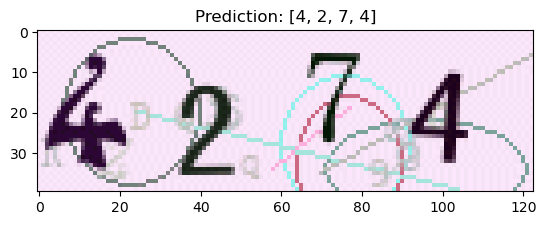

Enter T or F: t
1/1 [==============================] - 0s 48ms/step


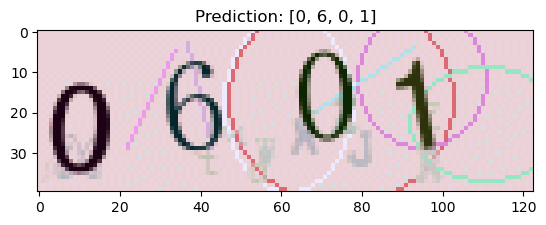

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


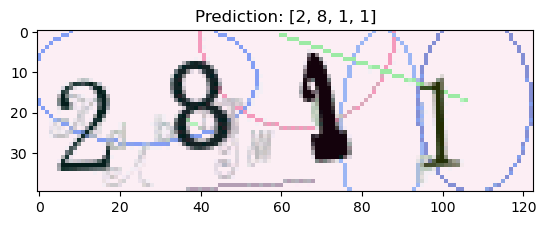

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


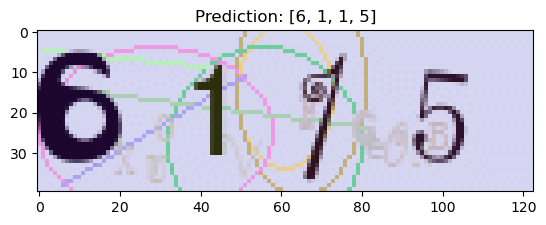

Enter T or F: t
1/1 [==============================] - 0s 44ms/step


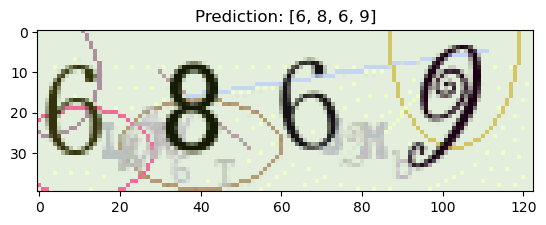

Enter T or F: t
1/1 [==============================] - 0s 33ms/step


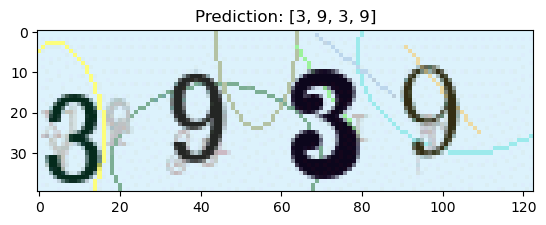

Enter T or F: t
1/1 [==============================] - 0s 39ms/step


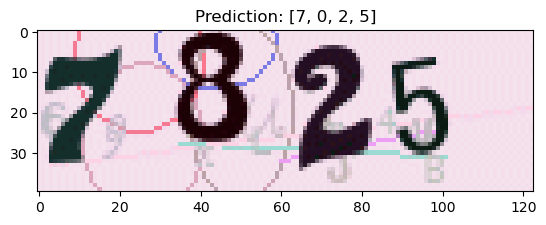

Enter T or F: f
1/1 [==============================] - 0s 40ms/step


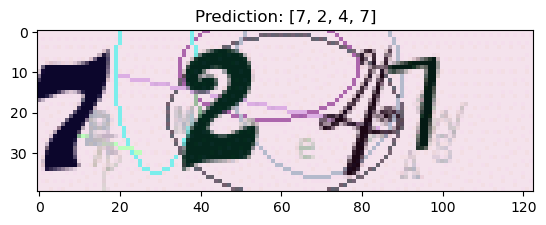

Enter T or F: t
1/1 [==============================] - 0s 52ms/step


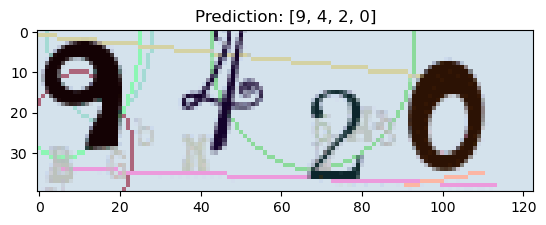

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


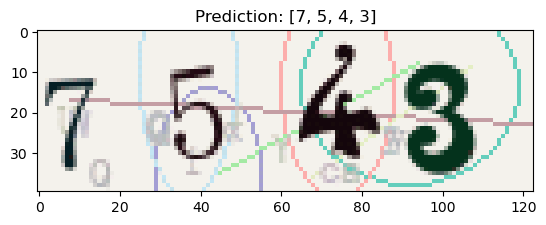

Enter T or F: t
1/1 [==============================] - 0s 45ms/step


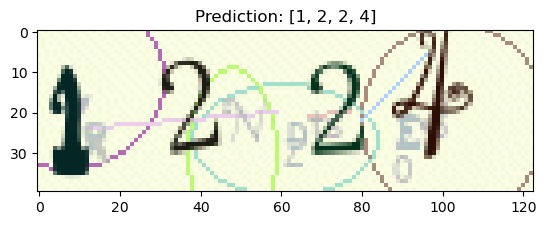

Enter T or F: t
1/1 [==============================] - 0s 42ms/step


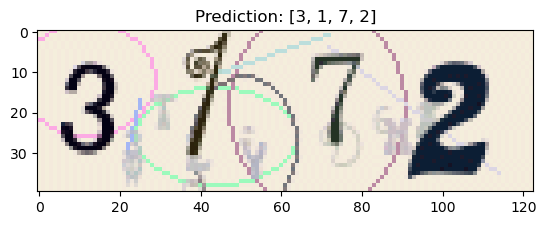

Enter T or F: t
1/1 [==============================] - 0s 42ms/step


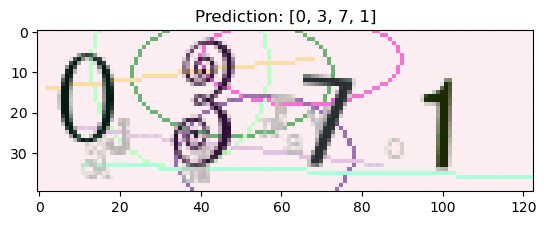

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


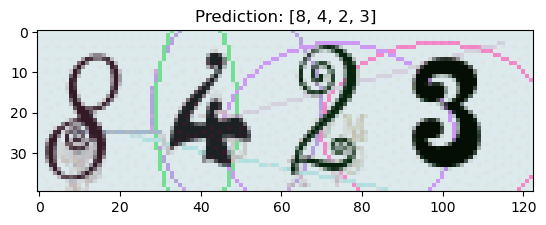

Enter T or F: t
1/1 [==============================] - 0s 45ms/step


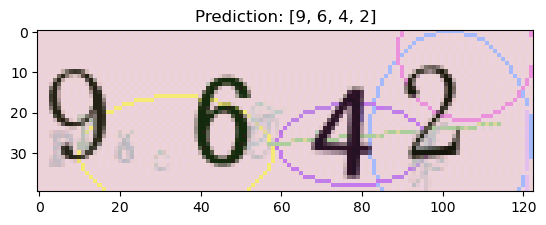

Enter T or F: t
1/1 [==============================] - 0s 41ms/step


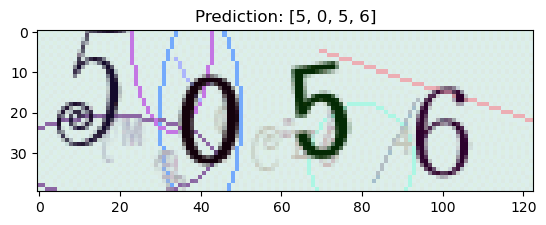

Enter T or F: t
1/1 [==============================] - 0s 51ms/step


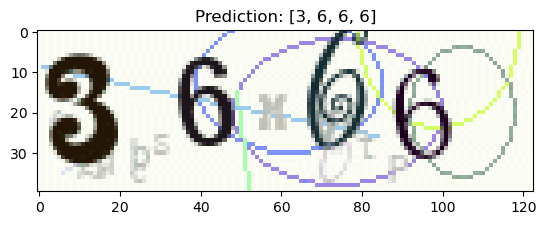

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


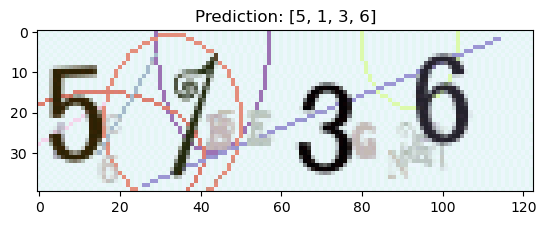

Enter T or F: t
1/1 [==============================] - 0s 43ms/step


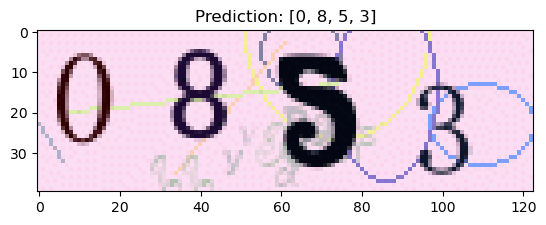

Enter T or F: t
1/1 [==============================] - 0s 39ms/step


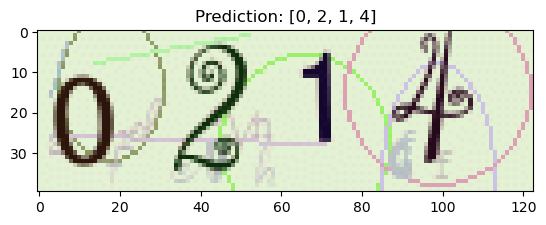

Enter T or F: t
1/1 [==============================] - 0s 44ms/step


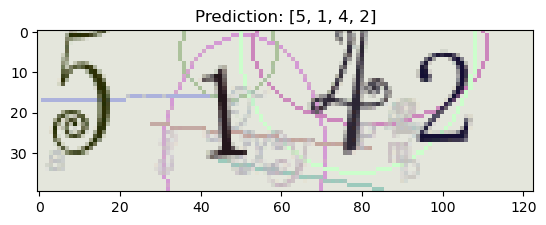

Enter T or F: t
The model predicted98.0% correctly.


In [65]:
answers = []
counter = 0
for image in glob.glob('../test_images/*'):
    counter += 1
    with Image.open(image).convert('RGB') as img:
        # Convert Pillow object to cv2 format
        captcha = np.asanyarray(img)
        captcha = captcha[:, :, ::-1].copy() 
    
        plt.title(f'Prediction for image number {}: {predict(captcha)}')
        plt.imshow(captcha)
        plt.show()
        
        answers.extend(input('Enter T or F: '))

print(f'\nThe model predicted {(answers.count("t") / len(answers))*100}% correctly.')